In [4]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
import transformers

## LOAD DATASET

In [6]:
df = pd.read_csv('datasets/my-dataset-train.csv')
df.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [7]:
df = df.dropna(subset=['text', 'label'])

In [8]:
df_train, df_test = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=30)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'], test_size=0.1, random_state=30)
print(df_train.shape, df_test.shape, df_val.shape)

(7729, 2) (955, 2) (859, 2)


## LOAD PRE-TRAINED MODEL

In [9]:
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')

In [10]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

def tokenize_function(dataset):
    return tokenizer(dataset["text"], padding="max_length", truncation=True)

dataset_train = dataset_train.map(tokenize_function, batched=True)
dataset_val = dataset_val.map(tokenize_function, batched=True)

small_train_dataset = dataset_train.shuffle(seed=42).select(range(1000))
small_eval_dataset = dataset_train.shuffle(seed=42).select(range(1000))

# dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
# dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
# dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 859/859 [00:00<00:00, 1731.52 examples/s]


## FINE TUNE MODEL (SKIP IF YOU ALREADY HAVE FINETUNED VERSION)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
model.eval()
trainer.predict(dataset_test).metrics

In [9]:
trainer.save_model('finbert-fintuned/')

NameError: name 'trainer' is not defined

## LOAD MODEL FOR EVALUATION

In [11]:
loadmodel = BertForSequenceClassification.from_pretrained('finbert-fintuned/')
loadmodel.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [26]:
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Subset

y_t = []
y_p = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loader = DataLoader(dataset=dataset_test, batch_size=64, shuffle=False)
for sample_batch in test_loader:
    # Print the keys of the sample batch to check its structure
    print(sample_batch.keys())
    # Break the loop after printing the first batch
    break



dict_keys(['text', 'label', '__index_level_0__'])


In [28]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

predicted_labels = []

for batch in test_loader:
    texts = batch['text']
    labels = batch['label']

    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
            outputs = loadmodel(**inputs)

    logits = outputs.logits
    _, predicted_batch = torch.max(logits, dim=1)

    y_t.extend(labels.tolist())
    y_p.extend(predicted_batch.tolist())

accuracy = accuracy_score(y_t, y_p)
precision = precision_score(y_t, y_p, average='weighted')
f1 = f1_score(y_t, y_p, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8817
Precision: 0.8820
F1 Score: 0.8808


In [29]:
print(y_t)
print(y_p)

[1, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 0, 1, 2, 0, 2, 2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 1, 1, 2, 0, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 2, 1, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 0, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 1, 0, 2, 0, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 0, 2, 1, 

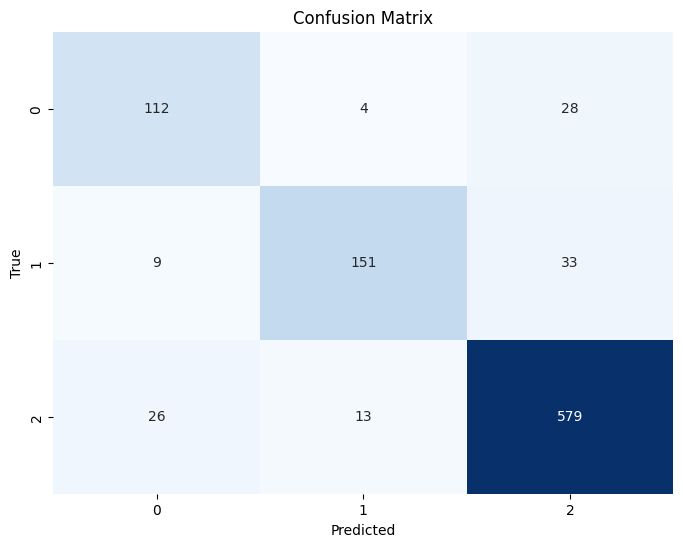

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_t, y_p)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [31]:
aapl_tweet_df = pd.read_csv('datasets/preprocessed-evaluation-tweets/aapl-15000.csv')
tsla_tweet_df = pd.read_csv('datasets/preprocessed-evaluation-tweets/tsla.csv')

aapl_price_df = pd.read_csv('stock_prices/AAPL_prices_2020-06-01_to_2020-07-25.csv')
#aapl_price_df = pd.read_csv('stock_prices/AAPL_prices_2022-01-01_to_2024-04-11.csv')
tsla_price_df = pd.read_csv('stock_prices/TSLA_prices_2022-01-01_to_2024-04-11.csv')

In [32]:
aapl_tweet_df.head()

,message,datetime,user,message_id
0,Peak profit for the last 6 expired option aler...,2020-07-19T09:49:35Z,1442893,229008387
1,$AAPL [Jul-17 382.50 Calls] Option volume Up +...,2020-07-19T09:47:26Z,1442893,229008357
2,$TSLA the market will be in true bubble territ...,2020-07-19T09:01:25Z,1115913,229007569
3,$AAPL was analyzed by 26 analysts. The buy con...,2020-07-19T08:13:00Z,47688,229006733
4,$AAPL NEW ARTICLE : Dogs Of The Dow For August...,2020-07-19T07:54:05Z,1555408,229006403


In [33]:
tweet_date_string = aapl_tweet_df['datetime'][0]
tweet_date_string = tweet_date_string[:10]
print(tweet_date_string)
print(type(tweet_date_string))

2020-07-19
<class 'str'>


In [34]:
price_date_string = tsla_price_df['Date'][0]
price_date_string = price_date_string[:10]
print(price_date_string)
print(type(price_date_string))

2022-01-03
<class 'str'>


In [37]:
text1 = "Apple is going up!"
inputs1 = tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
inputs1 = {k: v.to(device) for k, v in inputs1.items()}
outputs1 = loadmodel(**inputs1)
logits1 = outputs1.logits
predicted_class1 = torch.argmax(logits1, dim=1).item()

sentiment_labels = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
predicted_sentiment = sentiment_labels[predicted_class1]

print(f"Text: {text1}")
print(logits1[0].tolist())
print(f"Predicted Sentiment: {predicted_sentiment}\n")

text2 = "Tesla doesn't look too good today."
inputs2 = tokenizer(text2, return_tensors="pt", padding=True, truncation=True)
inputs2 = {k: v.to(device) for k, v in inputs2.items()}
outputs2 = loadmodel(**inputs2)
logits2 = outputs2.logits
predicted_class2 = torch.argmax(logits2, dim=1).item()

sentiment_labels = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
predicted_sentiment = sentiment_labels[predicted_class2]

print(f"Text: {text2}")
print(logits2[0].tolist())
print(f"Predicted Sentiment: {predicted_sentiment}\n")

print(logits1 + logits2)

Text: Apple is going up!
[-2.470505952835083, 3.166743040084839, -0.2714490592479706]
Predicted Sentiment: Positive

Text: Tesla doesn't look too good today.
[-0.6780800819396973, -0.8475140333175659, 1.984910011291504]
Predicted Sentiment: Neutral

tensor([[-3.1486,  2.3192,  1.7135]], grad_fn=<AddBackward0>)


In [65]:
from datetime import datetime

tweet_date_string = tsla_tweet_df['created_at'][0]

# Parse the string date into a datetime object
date_obj = datetime.strptime(tweet_date_string, "%a %b %d %H:%M:%S %z %Y")

# Format the datetime object into the desired format
formatted_date = date_obj.strftime("%Y-%m-%d")

print(formatted_date)
print(type(formatted_date))

2024-01-01
<class 'str'>


In [75]:
y_true = []
y_pred = []

for y in range(6, 8):
    month = str(y).zfill(2)
    for i in range(1,31):
        if y == 7 and i ==23:
            break
        
        date = str(i).zfill(2)
        date_string = f'2020-{month}-{date}'
        day_exist = False

        # check if prices fall or rise
        for index, Date in enumerate(aapl_price_df['Date']):
            if date_string == Date[:10]:
                if aapl_price_df['Close'][index+1] > aapl_price_df['Close'][index]:
                    y_true.append(1)
                else:
                    y_true.append(-1)
                day_exist = True
        if day_exist == False:
            continue
        else:
            day_exist = False

        # calculate sentiment on the day
        tweet_sentiments = torch.zeros(59, 3)
        for index, Date in enumerate(aapl_tweet_df['datetime']):
            formatted_date = Date[:10]

            if date_string == formatted_date:
                text = aapl_tweet_df['message'][index]

                inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
                with torch.no_grad():
                    outputs = loadmodel(**inputs)
                logits = outputs.logits
                tweet_sentiments += logits

        print(tweet_sentiments.tolist())
        #predicted_class = torch.argmax(tweet_sentiments, dim=1).item()
        k = 2  # We want the second largest element
        values, indices = torch.topk(tweet_sentiments[0], k)

        # The second largest element index will be at indices[1]
        second_largest_index = indices[1]

        predicted_class = second_largest_index.item()

        sentiment_labels = {0: -1, 1: 1, 2: 0}
        predicted_sentiment = sentiment_labels[predicted_class]

        if predicted_sentiment != 0:
            print('bear/bull')
            y_pred.append(predicted_sentiment)
        else:
            print('neutral')
            y_true.pop()

print('Tesla')
print(f'y_true: {y_true}')
print(f'y_pred: {y_pred}')

tsla_f1 = f1_score(y_true, y_pred, average='macro')
tsla_accuracy = accuracy_score(y_true, y_pred)

print(f'f1: {tsla_f1}')
print(f'accuracy: {tsla_accuracy}')


[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull
[[0.0, 0.0, 0.0]]
bear/bull


RuntimeError: output with shape [1, 3] doesn't match the broadcast shape [59, 3]